## Data from the Kaggle website

In [1]:
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
!unzip -q 'archive.zip'

--2024-07-22 03:17:54--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/yzldvhixewlfrtdatr3m9/archive.zip?rlkey=azh4epb0r6uqwe1vh74jctsnh [following]
--2024-07-22 03:17:54--  https://www.dropbox.com/scl/fi/yzldvhixewlfrtdatr3m9/archive.zip?rlkey=azh4epb0r6uqwe1vh74jctsnh
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf6142c7f0b5ce38d802a57e86f.dl.dropboxusercontent.com/cd/0/inline/CXJEgxrg1WS11eusBmkx1XJeax3kVNrGqYUYbMHhjtulZR4t6PAt2bYIOAewQRcV5qY8liNKUKuWFOACIthg9p7f08TSbnltR2YnBWJbxAY40daTXfnMoGNtuJ4OKXFnxgsgojrr-nUYvs9AgF26QTMk/file# [following]
--2024-07-22 03:17:55--  https://ucf6142c7f0b5ce38d802a57e86f.dl.dropboxusercontent.com/cd/0/inline/C

## The libraries I have used and their respective seeds


In [2]:
# Importing necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(2)

## Separating files with Pathlib


In [3]:
train_path = Path('chest_xray/train/')
validation_path = Path('chest_xray/test')
test_path = Path('chest_xray/val')

## Take all paths within the folders 'normal' and 'pneumonia'.


In [4]:
train_image_paths = train_path.glob('*/*')
val_image_paths = validation_path.glob('*/*')
print(train_image_paths)

<generator object Path.glob at 0x7b240d5b4a50>


## Convert generator object to List of elements

In [5]:
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)
print(train_image_paths[:3])

[PosixPath('chest_xray/train/NORMAL/IM-0437-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1161-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0680-0001.jpeg')]


## Convert X position to Strings

In [6]:
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths))
print(train_image_paths[:3])

['chest_xray/train/NORMAL/IM-0437-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1161-0001.jpeg', 'chest_xray/train/NORMAL/IM-0680-0001.jpeg']


##  Amount of data from training and validation datasets

In [7]:
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

# Data wrangling

In [8]:
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path: str) -> int:
    # Extract the label from the path by splitting the path string and using the second-to-last component
    return LABELS[path.split("/")[-2]]

# Generate the training labels by mapping the get_label function to each training image path
train_labels = list(map(lambda x: get_label(x), train_image_paths))

# Generate the validation labels by mapping the get_label function to each validation image path
val_labels = list(map(lambda x: get_label(x), val_image_paths))

print(train_labels[:3])

[0, 0, 0]


## Function to transform images and create an object in TF



In [25]:
size = 32

def load_and_transform(image, label, train=True):
    # Read the image file from the given path
    image = tf.io.read_file(image)
    # Decode the image as a JPEG file with 3 color channels (RGB)
    image = tf.io.decode_jpeg(image, channels=3)
    # Resize the image to 224x224 pixels using nearest neighbor interpolation
    image = tf.image.resize(image, [224, 224], method="nearest")
    # If training, randomly flip the image horizontally
    if train:
        image = tf.image.random_flip_left_right(image)
    # Return the processed image and its corresponding label
    return image, label

def get_dataset(paths, labels, train=True):
    # Convert the list of image paths and labels to tensors
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    # Create a dataset from the image paths
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    # Create a dataset from the labels
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    # Zip the image and label datasets together and shuffle the combined dataset
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset)).shuffle(1000)

    # Apply the load_and_transform function to each image-label pair
    dataset = dataset.map(lambda image, label: load_and_transform(image, label, train))
    # Repeat the dataset indefinitely
    dataset = dataset.repeat()
    # Shuffle the dataset with a buffer size of 2048
    dataset = dataset.shuffle(2048)
    # Batch the dataset into batches of size 32
    dataset = dataset.batch(size)

    # Return the prepared dataset
    return dataset

## Creation of a training and verification dataset.


In [10]:
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 1.3 s, sys: 230 ms, total: 1.53 s
Wall time: 2.92 s
(32, 224, 224, 3)
(32,)


## Samples of training images


PNEUMONIA


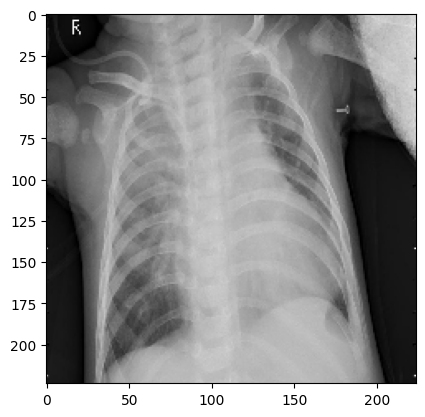

In [11]:
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [12]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 28.5 ms, sys: 145 µs, total: 28.7 ms
Wall time: 34 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


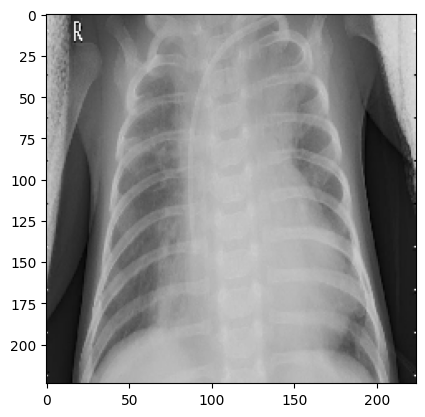

In [13]:
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [14]:
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 23521409 (89.73 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


## Compilation of the model with the optimizer, missing data and its metrics

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    # Set the loss function to binary cross-entropy, suitable for binary classification problems
    loss='binary_crossentropy',
    # Track accuracy, precision, and recall metrics during training
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [16]:
# Create a ModelCheckpoint callback to save the model weights when the monitored metric improves
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    # Filepath to save the model weights
    "best_weights.h5",
    # Verbosity mode, 1 = progress bar
    verbose=1,
    # Save only the best model based on the monitored metric
    save_best_only=True,
    # Save only the model weights, not the entire model
    save_weights_only=True
)

# Create an EarlyStopping callback to stop training when the monitored metric has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(
    # Number of epochs with no improvement after which training will be stopped
    patience=4
)

## Model training

In [17]:
history = model.fit(
    train_dataset,
    # Number of batches per epoch during training
    steps_per_epoch=train_dataset_length // size,
    # Number of epochs to train the model
    epochs=10,
    # List of callbacks to apply during training
    callbacks=[checkpoint, early_stop],
    # Dataset to evaluate the validation loss and metrics at the end of each epoch
    validation_data=val_dataset,
    # Number of batches to draw from the validation dataset at each epoch
    validation_steps=val_dataset_length // size,
)


Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9417 - precision: 0.9552 - recall: 0.9563
Epoch 1: val_loss improved from inf to 12.99627, saving model to best_weights.h5
163/163 [==============================] - 143s 499ms/step - loss: 0.1492 - accuracy: 0.9417 - precision: 0.9552 - recall: 0.9563 - val_loss: 12.9963 - val_accuracy: 0.5444 - val_precision: 0.6018 - val_recall: 0.7371
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9680 - precision: 0.9764 - recall: 0.9806
Epoch 2: val_loss improved from 12.99627 to 0.78364, saving model to best_weights.h5
163/163 [==============================] - 79s 483ms/step - loss: 0.0862 - accuracy: 0.9680 - precision: 0.9764 - recall: 0.9806 - val_loss: 0.7836 - val_accuracy: 0.8191 - val_precision: 0.9587 - val_recall: 0.7569
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 0.9739 - precision: 0.9815 - recall: 0.9835
E

## Interpretation of metrics

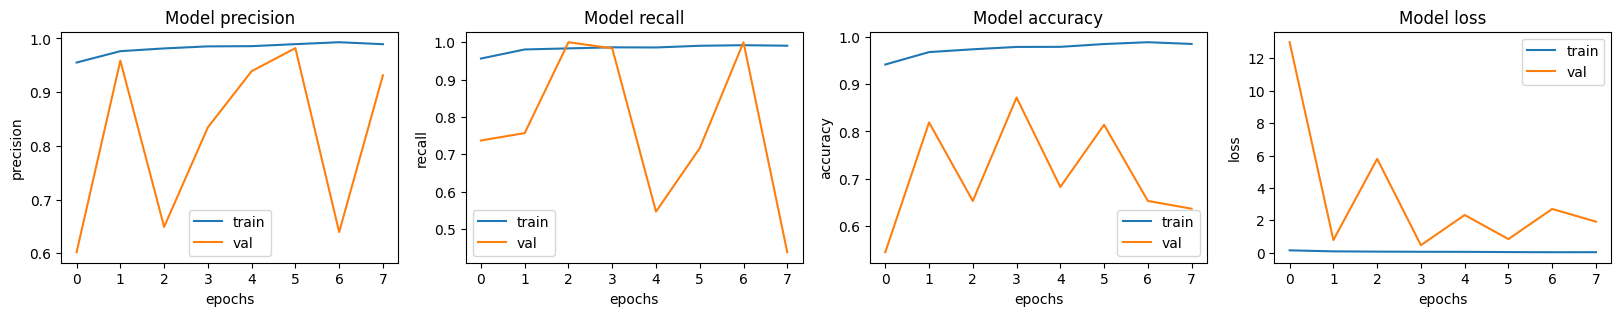

In [27]:
# Create a figure with 1 row and 4 columns of subplots, setting the figure size
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
# Flatten the array of axes for easy iteration
ax = ax.ravel()

# Iterate over the metrics and plot their values for each epoch
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    # Plot the training metric values
    ax[i].plot(history.history[met])
    # Plot the validation metric values
    ax[i].plot(history.history['val_' + met])
    # Set the title of the subplot to the name of the metric
    ax[i].set_title('Model {}'.format(met))
    # Set the x-axis label to 'epochs'
    ax[i].set_xlabel('epochs')
    # Set the y-axis label to the metric name
    ax[i].set_ylabel(met)
    # Add a legend to distinguish between training and validation metrics
    ax[i].legend(['train', 'val'])

## Updated Code with Dropout and L2 Regularization:


In [28]:
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    # Add dropout with a rate of 0.5
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)


In [30]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_weights.h5",
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

early_stop = tf.keras.callbacks.EarlyStopping(
    patience=4  # Number of epochs with no improvement after which training will be stopped
)

In [31]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length // size,
    epochs=10,
    callbacks=[checkpoint, early_stop],
    validation_data=val_dataset,
    validation_steps=val_dataset_length // size,
)


Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 18.4330 - accuracy: 0.8388 - precision: 0.8779 - recall: 0.8792
Epoch 1: val_loss improved from inf to 6.32688, saving model to best_weights.h5
163/163 [==============================] - 100s 426ms/step - loss: 18.4330 - accuracy: 0.8388 - precision: 0.8779 - recall: 0.8792 - val_loss: 6.3269 - val_accuracy: 0.7697 - val_precision: 0.7352 - val_recall: 0.9841
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 4.3647 - accuracy: 0.9331 - precision: 0.9520 - recall: 0.9572
Epoch 2: val_loss improved from 6.32688 to 3.63285, saving model to best_weights.h5
163/163 [==============================] - 68s 421ms/step - loss: 4.3647 - accuracy: 0.9331 - precision: 0.9520 - recall: 0.9572 - val_loss: 3.6329 - val_accuracy: 0.8109 - val_precision: 0.9132 - val_recall: 0.7634
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 2.7864 - accuracy: 0.9317 - precision: 0.9501 - recall: 0.9589
Ep

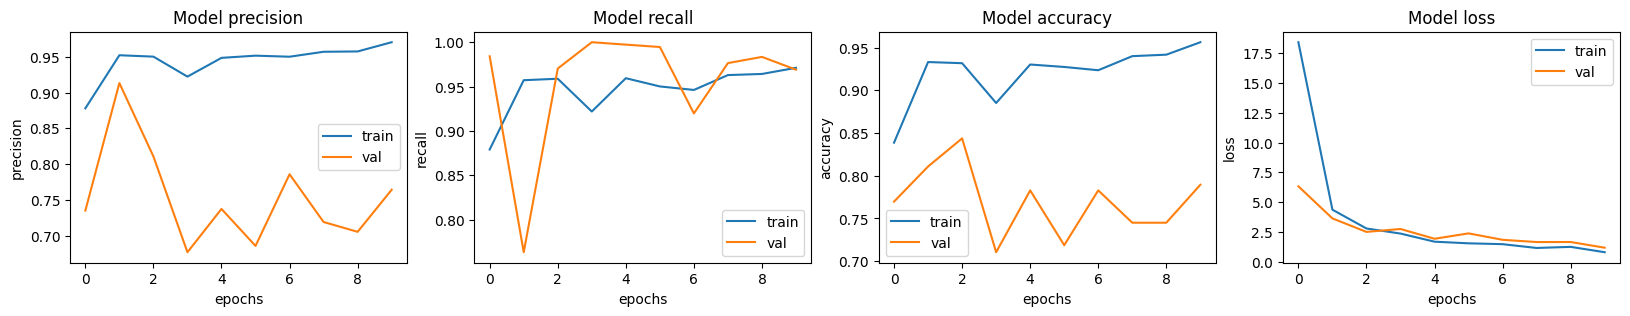

In [32]:
# Create a figure with 1 row and 4 columns of subplots, setting the figure size
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
# Flatten the array of axes for easy iteration
ax = ax.ravel()

# Iterate over the metrics and plot their values for each epoch
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    # Plot the training metric values
    ax[i].plot(history.history[met])
    # Plot the validation metric values
    ax[i].plot(history.history['val_' + met])
    # Set the title of the subplot to the name of the metric
    ax[i].set_title('Model {}'.format(met))
    # Set the x-axis label to 'epochs'
    ax[i].set_xlabel('epochs')
    # Set the y-axis label to the metric name
    ax[i].set_ylabel(met)
    # Add a legend to distinguish between training and validation metrics
    ax[i].legend(['train', 'val'])

plt.show()

## Save the best model

In [33]:
model.load_weights("best_weights.h5")
model.save("model.h5")

## Complete model

In [34]:
loaded_model = tf.keras.models.load_model("model.h5")

## Create a 'test' dataset

In [35]:
# Generate a list of paths for test images by recursively finding all files in the test_path directory.
test_image_paths = list(test_path.glob("*/*"))

# Convert each path from a Path object to a string.
test_image_paths = list(map(lambda x: str(x), test_image_paths))

# Extract labels for each test image using the get_label function.
test_labels = list(map(lambda x: get_label(x), test_image_paths))

# Convert the list of image paths to a TensorFlow tensor.
test_image_paths = tf.convert_to_tensor(test_image_paths)

# Convert the list of labels to a TensorFlow tensor.
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image, label):
    # Read the image file from the given path.
    image = tf.io.read_file(image)

    # Decode the image as a JPEG file, with 3 color channels (RGB).
    image = tf.io.decode_jpeg(image, channels=3)

    # Resize the image to 224x224 pixels using nearest neighbor interpolation.
    image = tf.image.resize(image, [224, 224], method="nearest")

    # Return the processed image and its corresponding label.
    return image, label

# Create a TensorFlow dataset from the tensors of image paths and labels.
test_dataset = (
    tf.data.Dataset
    # Create a dataset from the slices of image paths and labels.
    .from_tensor_slices((test_image_paths, test_labels))
    # Apply the decode_image function to each element in the dataset.
    .map(decode_image)
    # Batch the dataset elements into batches of the specified size.
    .batch(size)
)


## Samples of validation images

In [36]:
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


NORMAL


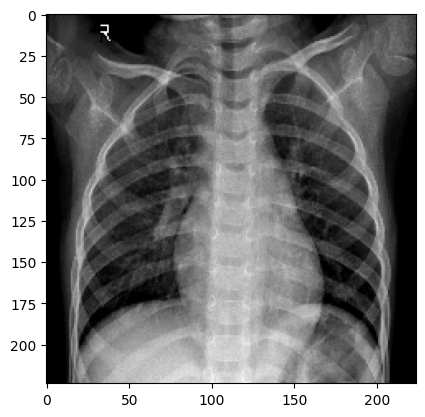

In [37]:
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

## Model evaluation

In [38]:
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 [==============================] - 1s 973ms/step - loss: 1.0800 - accuracy: 0.6875 - precision: 0.6364 - recall: 0.8750
 Testing Acc :  0.6875
 Testing Precision  0.6363636255264282
 Testing Recall  0.875
